<font color='blue'> **SFR** </font><font color='orange'> **_____________________________________________________________________________________________ RUN GWF** </font> 

In [1]:
from modflow_devtools.misc import get_env;write=get_env("WRITE",True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True) 
from pathlib import Path ; import shutil  ; import matplotlib.pyplot as plt ; import numpy as np ; import pandas as pd ; import flopy ; import sys ; from flopy.plot.styles import styles 
_R=Path("./_R");_R.mkdir(exist_ok=True);T51=Path("./_R/T51");T51.mkdir(exist_ok=True)                                       ; plt.rcParams['font.size'] = 14   ;ID="e51" 
import os # ; os.startfile('E:/15_REPOS/02_Beta-Me/Beta_xls/51_ex-gwt_LIST.xlsx')
#import xlwings as xw ; wb = xw.Book('E:/15_REPOS/02_Beta-Me/Beta_xls/51_e51_b.xlsx')  ; wb.sheets['51'].activate()     ; 

In [2]:
length_units = "feet" ;time_units = "days" ;hk = 250 ;vk = 125           ;ss = 0 ;aquifer_thickness = 120  ;porosity = 0.3 ;recharge = 0.00479 ;nlay = 8    ;nrow = 36 
LAK_B = 1 ;streambed_k = 100  ; streambed_thick = 1   ;stream_width = 5   ;manning = 0.03   ;alpha_l = 20   ;alpha_th = 2   ;alpha_tv = 0.2     ;diffc = 0   ;cstrt = 0 ;source_concentration = 500
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/51')    ; ncol = 23         ;delr = 405.665   ;delc = 403.717 ;delv = 15      ;top = 100          ;total_time = 9131

F01 = "bot1.dat"      ; BO0 = np.loadtxt(REF1/F01)             ; botm = [BO0]+[BO0-(15.0*k) for k in range(1, nlay)]    ; pd.DataFrame(botm[7]).to_csv(T51/ '_06_Bot_0.csv') ; print(len(botm))
F02 = "idomain1.dat"  ; ID0 = np.loadtxt(REF1/F02, dtype=int)  ; idomain = nlay * [ID0]                                 ; pd.DataFrame(botm[7]).to_csv(T51/'_06b_Bot_8.csv') 
F03 = "lakibd.dat"    ; LB0 = np.loadtxt(REF1/F03, dtype=int)  ; pd.DataFrame(LB0).to_csv(T51/'_05_LAK_LAK_M.csv')             # AA=[[1],[2],[3]] ; AA[1].append(-31) ; AA
F04 = "stream.csv"    ; dt = 5 * [int] + [float]               ; STR = np.genfromtxt(REF1/F04, names=True, delimiter=",", dtype=dt)

8


In [3]:
STR

array([(1,  1, 23, 1,  1, 400.), (1,  2, 23, 1,  2, 200.),
       (1,  2, 22, 1,  3, 400.), (1,  3, 21, 1,  4, 400.),
       (1,  4, 20, 1,  5, 400.), (1,  5, 20, 1,  6, 400.),
       (1, 17, 18, 2,  1, 400.), (1, 18, 18, 2,  2, 400.),
       (1, 19, 18, 2,  3, 400.), (1, 20, 17, 2,  4, 400.),
       (1, 21, 17, 2,  5, 400.), (1, 22, 17, 2,  6, 400.),
       (1, 23, 16, 2,  7, 400.), (1, 24, 16, 2,  8, 400.),
       (1, 25, 16, 2,  9, 400.), (1, 26, 16, 2, 10, 400.),
       (1, 27, 16, 2, 11, 400.), (1, 28, 15, 2, 12, 400.),
       (1, 18, 11, 3,  1, 400.), (1, 19, 11, 3,  2, 200.),
       (1, 19, 12, 3,  3, 200.), (1, 20, 12, 3,  4, 400.),
       (1, 21, 12, 3,  5, 400.), (1, 22, 13, 3,  6, 400.),
       (1, 23, 13, 3,  7, 400.), (1, 24, 13, 3,  8, 200.),
       (1, 24, 14, 3,  9, 200.), (1, 25, 14, 3, 10, 400.),
       (1, 26, 14, 3, 11, 400.), (1, 27, 14, 3, 12, 400.),
       (1, 28, 15, 3, 13, 400.), (1, 29, 15, 4,  1, 400.),
       (1, 30, 15, 4,  2, 400.), (1, 31, 15, 4,  3, 400.

In [4]:
def get_stream_data():
    SFR_P = [[IR] for IR in range(STR.shape[0])]                               ; isegold = -1                            ; SEGD = [] ; distance = 0
    for IR, row in enumerate(STR):   
        iseg = row["seg"] - 1
        if iseg == isegold:
            SFR_P[IR].append(IR-1)        ; SFR_P[IR-1].append(-IR)             ;distance+=(STR["length"][IR - 1] * 0.5+ STR["length"][IR] * 0.5)
        else:                              distance = 0.5 * STR["length"][IR]
        isegold = iseg                   ; SEGD.append(distance)
    SFR_P[17].append(-31)                 ; SFR_P[31].append(17)                ; SFR_P[30].append(-31)    ; SFR_P[31].append(30) 
    
    SFR_C = [] ; segment_lengths = []
    for iseg in [1, 2, 3, 4]:        idx = np.where(STR["seg"] == iseg) ; segment_length = STR["length"][idx].sum() ; segment_lengths.append(segment_length)
    emaxmin = [(49, 45), (44.5, 34), (41.5, 34.0), (34.0, 27.2)] ; segment_gradients = []
    for iseg, (emax, emin) in enumerate(emaxmin): segment_gradients.append((emax - emin) / segment_lengths[iseg])
    ustrf = 1.0 ; ndv = 0
    for IR, row in enumerate(STR):
        k,i,j = row["layer"]-1, row["row"]-1, row["col"]-1              ; length = row["length"]               ; iseg = row["seg"] - 1  ; rgrd = segment_gradients[iseg]
        emax, emin = emaxmin[iseg]          ; rtp=SEGD[IR]/segment_lengths[iseg]*(emax-emin)                   ; rtp  = emax - rtp      ; boundname = f"SEG{iseg + 1}"
        rec = (IR,(k, i, j),length,stream_width,rgrd,rtp,streambed_thick,streambed_k,manning,len(SFR_P[IR]) - 1 , ustrf,ndv,boundname,)  ; SFR_C.append(rec)
    return SFR_C, SFR_P

In [5]:
SFR_P, SFR_C = get_stream_data()                ; SFR_S = {0: [[0,"inflow",86400], [18,"inflow",8640.0]]}  ; PER=[["SFR-1",5,"LAK-1",0,"FACTOR",1.0] ,["LAK-1",0,"SFR-1",6,"FACTOR",1.0]]
shutil.copy(REF1 / F04, T51/'_01_stream.csv')   ; pd.DataFrame(SFR_P).to_csv(T51/'_02_SFR_P.csv')            ; pd.DataFrame(SFR_C).to_csv(T51/'_03_SFR_C.csv')
shutil.copy(REF1 / 'chd.dat', T51/'_04_chd.dat')

WindowsPath('_R/T51/_04_chd.dat')

In [6]:
def build_MF6_F(SIM):
    global LAK_B,LAK_D,LAK_C,LAK_P,LAK_M,idomain,OUT  ;name="flow"      ;LAK_M=np.ones((nlay,nrow,ncol),dtype=np.int32)*-1 ;LAK_M[0,:,:]=LB0[:,:]-1      ;chdlist=[]
    for line in open(REF1/'chd.dat').readlines(): 
        ll = line.strip().split()
        if len(ll) == 4:    
            k, i, j, hd = ll                 ; chdlist.append([(int(k)-1 ,int(i)-1 ,int(j)-1) ,float(hd)])
            
    SFR_O = {(name + ".sfr.obs.csv",)  : [("reach1leakage", "SFR", "SEG1") ,("reach2leakage", "SFR", "SEG2") ,("reach3leakage","SFR","SEG3") ,("reach4leakage","SFR","SEG4")]}  # __ 4
    SFR_O["digits"] = 7                ; SFR_O["print_input"] = True        ;SFR_O["filename"]=name+".sfr.obs"

    sim = flopy.mf6.MFSimulation (sim_name=name, sim_ws=T51/SIM/"MF6_F", exe_name="mf6")                                  ; tdis_data = [(total_time, 1, 1.0)]
    flopy.mf6.ModflowTdis        (sim, nper=len(tdis_data), perioddata=tdis_data, time_units=time_units)
    flopy.mf6.ModflowIms         (sim, print_option="summary",outer_maximum=1000,inner_maximum=50,outer_dvclose=0.01,inner_dvclose=0.01,relaxation_factor=0.99)
    gwf = flopy.mf6.ModflowGwf   (sim, modelname=name, save_flows=True)                                                                                 ; flopy.mf6.ModflowGwfic (gwf, strt=50.0)
    dis = flopy.mf6.ModflowGwfdis(gwf, length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain)   ; idomain = dis.idomain.array
    flopy.mf6.ModflowGwfnpf      (gwf, save_specific_discharge=True,save_saturation=True,icelltype=[1] + 7 * [0],k=hk,k33=vk)                           ; HF=f"{name}.hds";BF=f"{name}.bud" 
    flopy.mf6.ModflowGwfoc       (gwf, head_filerecord=HF,budget_filerecord=BF,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    flopy.mf6.ModflowGwfrcha     (gwf, recharge={0: recharge}, pname="RCH-1")      ; flopy.mf6.ModflowGwfchd (gwf, stress_period_data=chdlist, pname="CHD-1")
    (LAK_I, LAK_D, LAK_C)      = (flopy.mf6.utils.get_lak_connections(gwf.modelgrid, LAK_M, idomain=idomain, bedleak=LAK_B))
    gwf.dis.idomain.set_data(LAK_I[0],layer=0,multiplier=[1])   ;LAK_P=[[0,44.0,LAK_D[0],"lake1"],[1,35.2,LAK_D[1],"lake2"]]   ;OUT=[[0,0,-1,"MANNING",44.5,3.36493214532915,0.03,0.2187500e-02]]

    flopy.mf6.ModflowGwflak     (gwf,time_conversion=86400.000,length_conversion=3.28081,print_stage=True,print_flows=True,stage_filerecord=name+".lak.bin",budget_filerecord=name+".lak.bud",
                                mover=True,pname="LAK-1",boundnames=True,nlakes=len(LAK_P),noutlets=len(OUT),outlets=OUT,packagedata=LAK_P ,  connectiondata=LAK_C)
    
    flopy.mf6.ModflowGwfsfr     (gwf,print_stage=True,print_flows=True,stage_filerecord=name + ".sfr.bin",budget_filerecord=name + ".sfr.bud",mover=True,pname="SFR-1",time_conversion=86400.000,
                                length_conversion=3.28081,boundnames=True                     ,nreaches=len(SFR_C) ,packagedata=SFR_P ,connectiondata=SFR_C ,perioddata=SFR_S,observations=SFR_O)
    flopy.mf6.ModflowGwfmvr     (gwf,maxmvr=2,print_flows=True,budget_filerecord=name + ".mvr.bud",maxpackages=2,packages=[["SFR-1"], ["LAK-1"]],perioddata=PER)         ;return sim

In [7]:
%%capture   
MF6_F = build_MF6_F(ID)   ; MF6_F.write_simulation(silent='silent')      ; MF6_F.run_simulation(silent='silent', report=True)

<font color='orange'> **PLOT_01 _____________________________________________________________________________________________** </font> 

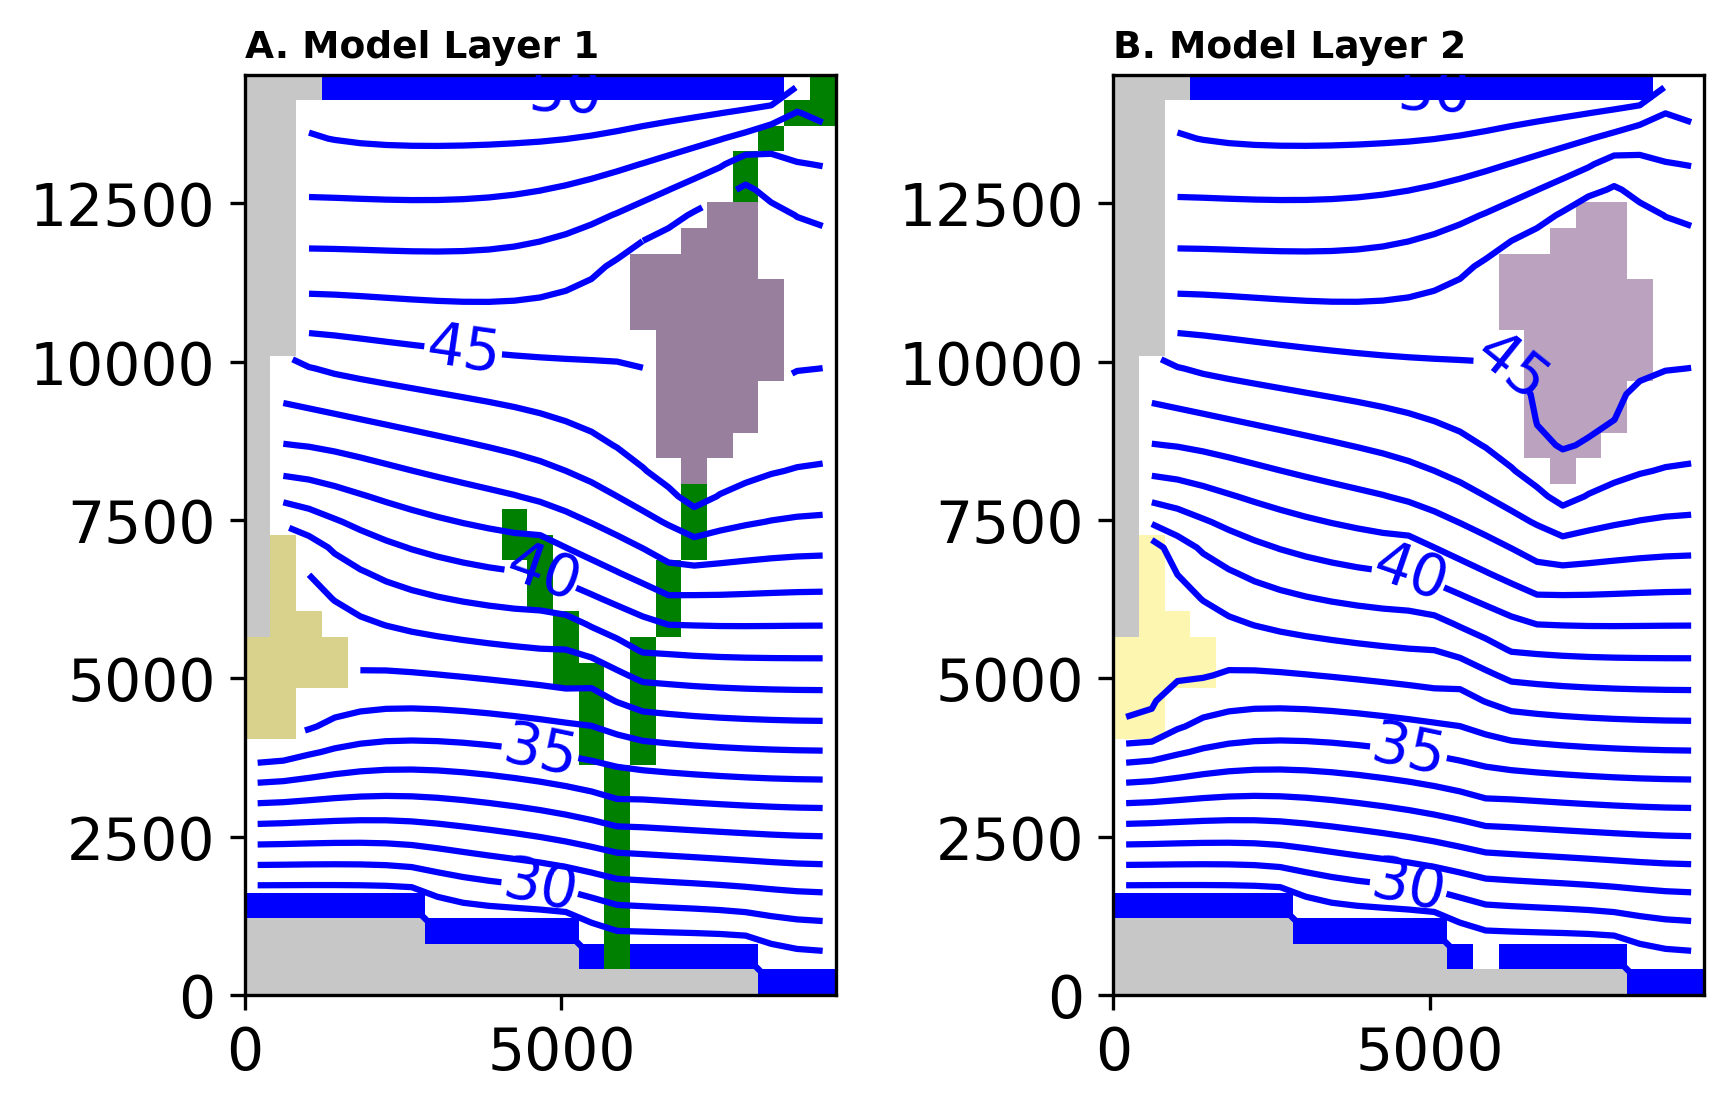

In [12]:
def plot_bcmap(ax, gwf, layer=0):
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=layer)   ; pmv.plot_inactive(color_noflow="gray", alpha=0.25)    ; pmv.plot_array(LB0, masked_values=[0], alpha=0.2)
    pmv.plot_bc(name="CHD-1", color="blue")                       ; pmv.plot_bc(name="SFR-1", color="green")              ; ax.set_aspect("equal")  ; return pmv

gwf = MF6_F.flow   ; HEAD = gwf.output.head().get_data()     #; STAGE = gwf.lak.output.stage().get_data().flatten() 

fig, axs = plt.subplots(1, 2, figsize=(6, 6), dpi=300, tight_layout=True)
for ilay in [0, 1]:
    ax = axs[ilay]  ; pmv = plot_bcmap(ax, gwf, ilay)     ; levels = np.arange(20, 60, 1)
    cs = pmv.contour_array(HEAD,colors="blue",linestyles="-",levels=levels,masked_values=[1.0e30],) ; ax.clabel(cs, cs.levels[::5], fmt="%1.0f", colors="b")          
    title = f"Model Layer {ilay + 1}"   ; letter = chr(ord("@") + ilay + 1)   ; styles.heading(letter=letter, heading=title, ax=ax)  #; plt.close() # plt.show()

fig.savefig(T51 / '_FIG1') ; os.startfile(T51 / '_FIG1.png') # _________________________________________________________________________________________ #  HEADS L1,2
#fig = plt.figure(figsize=(16, 4))                           # _________________________________________________________________________________________ #  Botm | GRID     
#ax1 = fig.add_subplot(161) ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)     ; mm.plot_grid()   ; mm.plot_ibound() 
#ax2 = fig.add_subplot(162) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array([BO0])  ; ax2.set_title('Bottom')  
#ax2.yaxis.set_visible(False) ; plt.colorbar(pc, shrink=0.8) ; plt.show()

In [9]:
pd.DataFrame(idomain[0]).to_csv(T51/'_08_idomain.csv')          ; pd.DataFrame(LAK_C).to_csv(T51/'_07_LAK_C.csv')    #outlets
pd.DataFrame(idomain[0]).to_csv(T51/'_08_idomain.csv')          ; pd.DataFrame(os.listdir(T51/'e51'/'MF6_F')).to_csv(T51/"L51_LIST.csv")  

In [10]:
LAK_D

{0: 78, 1: 32}

In [11]:
# https://flopy.readtHFocs.io/en/3.9.1/_modules/flopy/mf6/utils/lakpak_utils.html
# https://modflow6-examples.readtHFocs.io/en/develop/_notebooks/ex-gwf-sfr-p01b.html